In [1]:
from pyspark.sql import SparkSession

spark= SparkSession.builder.appName("trip_count_sql").getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/13 06:28:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# 디렉토리 지정, 여러 개의 파일을 한번에 불러오기
directory = "/home/ubuntu/working/spark-examples/data"
trip_files = "/trips/*" # 에스터리스크를 활용하여 trips 디렉토리 내의 모든 파일을 불러오기
zone_file = "taxi+_zone_lookup.csv"

trip_df = spark.read.csv(f"file://{directory}/{trip_files}",inferSchema=True, header=True)
zone_df = spark.read.csv(f"file://{directory}/{zone_file}",inferSchema=True, header=True)

In [3]:
# 스키마 확인
trip_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



### Data Lake -> Data Warehouse (데이터들을 join을 통해 하나의 데이터로 통합하는 과정)
- EDA 과정

In [8]:
trip_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [9]:
query = """
SELECT
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
    
FROM trips t
LEFT JOIN
    zone pz
ON t.PULocationID = pz.LocationID
LEFT JOIN
    zone dz
ON t.DOLocationID = dz.LocationID
"""

comb_df = spark.sql(query)
comb_df.createOrReplaceTempView("comb")

In [10]:
comb_df.show(5)

+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+-----------------+--------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|      pickup_zone|  dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+-----------------+--------------+
|        2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|        3.0|       0.0|         0.0|         4.3|           2|               NV|            NV|
|        2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|        2.5|       0.0|         0.0|         3.8|           2|   Manhattanville|Manhattanville|
|        2| 2021-03-01|  2021-03-01|          0|           0|    

In [12]:
query = """
SELECT pickup_date, pickup_time
FROM comb
WHERE pickup_time > 0
ORDER BY pickup_date
"""

spark.sql(query).show()

# 오류가 있는 데이터가 있는지 확인활 것!

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2002-12-31|         23|
| 2003-01-05|          7|
| 2004-04-04|          4|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         22|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
+-----------+-----------+
only showing top 20 rows



In [14]:
query = """
SELECT pickup_date, pickup_time
FROM comb
WHERE pickup_date < "2020-12-31"
ORDER BY pickup_date
"""

spark.sql(query).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2002-12-31|         23|
| 2003-01-05|          7|
| 2004-04-04|          4|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         22|
| 2008-12-31|         23|
+-----------+-----------+
only showing top 20 rows



In [15]:
# 요금 데이터 확인
comb_df.select("total_amount").describe().show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|         15000700|
|   mean|18.75545205708744|
| stddev|145.7442452805979|
|    min|           -647.8|
|    max|         398469.2|
+-------+-----------------+



min이 음수인 데이터도 존재. max는 4억원....?

In [16]:
# 거리 데이터 확인
comb_df.select("trip_distance").describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000700|
|   mean|6.628629402627818|
| stddev|671.7293482115828|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



In [19]:
# 승객 수 데이터 확인
comb_df.select("passenger_count").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166672|
|   mean|1.4253783104458126|
| stddev|  1.04432704905968|
|    min|                 0|
|    max|                 9|
+-------+------------------+



In [20]:
# 월 별 운행 수 확인  
query= """
    SELECT DATE_TRUNC("MM",c.pickup_date) AS month, count(*) as trips
    FROM comb c
    GROUP BY month
    ORDER BY month desc
"""

spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821430|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371688|
|2021-01-01 00:00:00|1369749|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



## 살펴본 내용들을 토대로 실제 분석할 데이터로 정제. Warehouse -> Mart

In [23]:
# Date 정제
query = """
SELECT *
FROM comb c
WHERE c.total_amount < 50000
    AND c.total_amount > 0
    AND c.passenger_count < 5
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2021-08-01'
"""

cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")


In [24]:
cleaned_df.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+-------------------+--------------------+--------------------+
|summary|         vendor_id|       pickup_time|     dropoff_time|   passenger_count|     trip_distance|       fare_amount|       tip_amount|       tolls_amount|      total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+-------------------+--------------------+--------------------+
|  count|          13499530|          13499530|         13499530|          13499530|          13499530|          13499530|         13499530|           13499530|          13499530|           13499530|            13499530|            13499530|
|   mean|1.6724005946873706|14.2

# 시각화
- 그냥 `제플린` 써

In [26]:
!pip install seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 6.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 66.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 78.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 79.6 MB/s eta 0:00:00:00:01


In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
# pickup_date 별 운행 수 확인
query = """
SELECT c.pickup_date, count(pickup_date) as trips
FROM cleaned c
GROUP BY c.pickup_date
"""

# 쿼리 실행의 결과를 판다스 데이터프레임으로 바꿔서 시각화를 해야함
pd_df = spark.sql(query).toPandas() # toPandas()도 액셕
pd_df

,pickup_date,trips
0,2021-03-22,53031
1,2021-03-07,34865
2,2021-03-21,40258
3,2021-05-27,84245
4,2021-03-14,39323
...,...,...
207,2021-03-30,59434
208,2021-03-27,60761
209,2021-03-29,51334
210,2021-04-27,68779


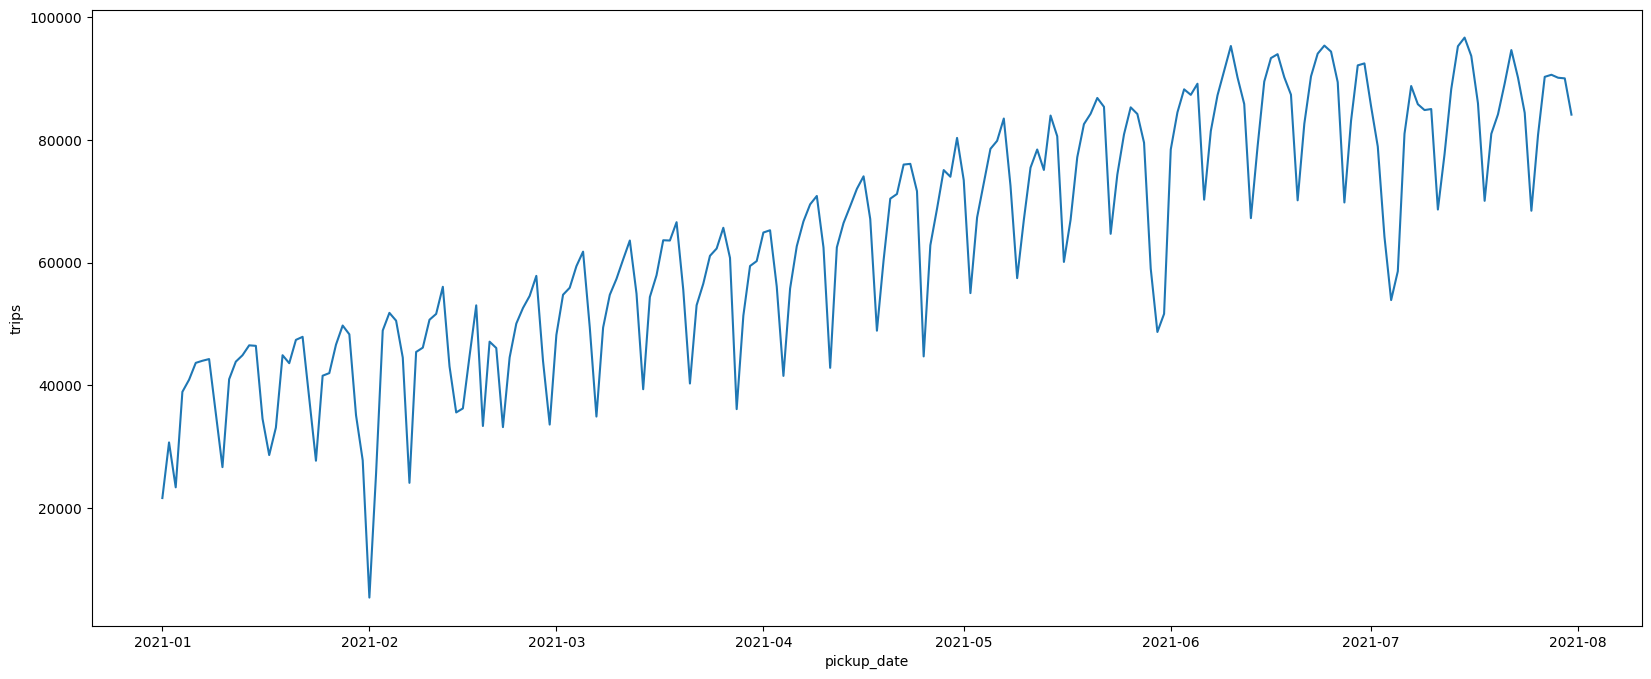

In [30]:
plt.subplots(figsize=(20, 8))
sns.lineplot(x='pickup_date', y='trips', data = pd_df)
plt.show()

In [31]:
# 요일 별 중간값 확인
query= """
SELECT pickup_date,
       DATE_FORMAT(pickup_date, "EEEE") as day_of_week,
       count(*) as trips
FROM cleaned
GROUP BY pickup_date, day_of_week
"""
pd_df2 = spark.sql(query).toPandas()
pd_df2

,pickup_date,day_of_week,trips
0,2021-03-24,Wednesday,61095
1,2021-03-03,Wednesday,55886
2,2021-03-05,Friday,61779
3,2021-03-09,Tuesday,54732
4,2021-03-26,Friday,65675
...,...,...,...
207,2021-03-30,Tuesday,59434
208,2021-04-24,Saturday,71646
209,2021-03-28,Sunday,36076
210,2021-04-25,Sunday,44682


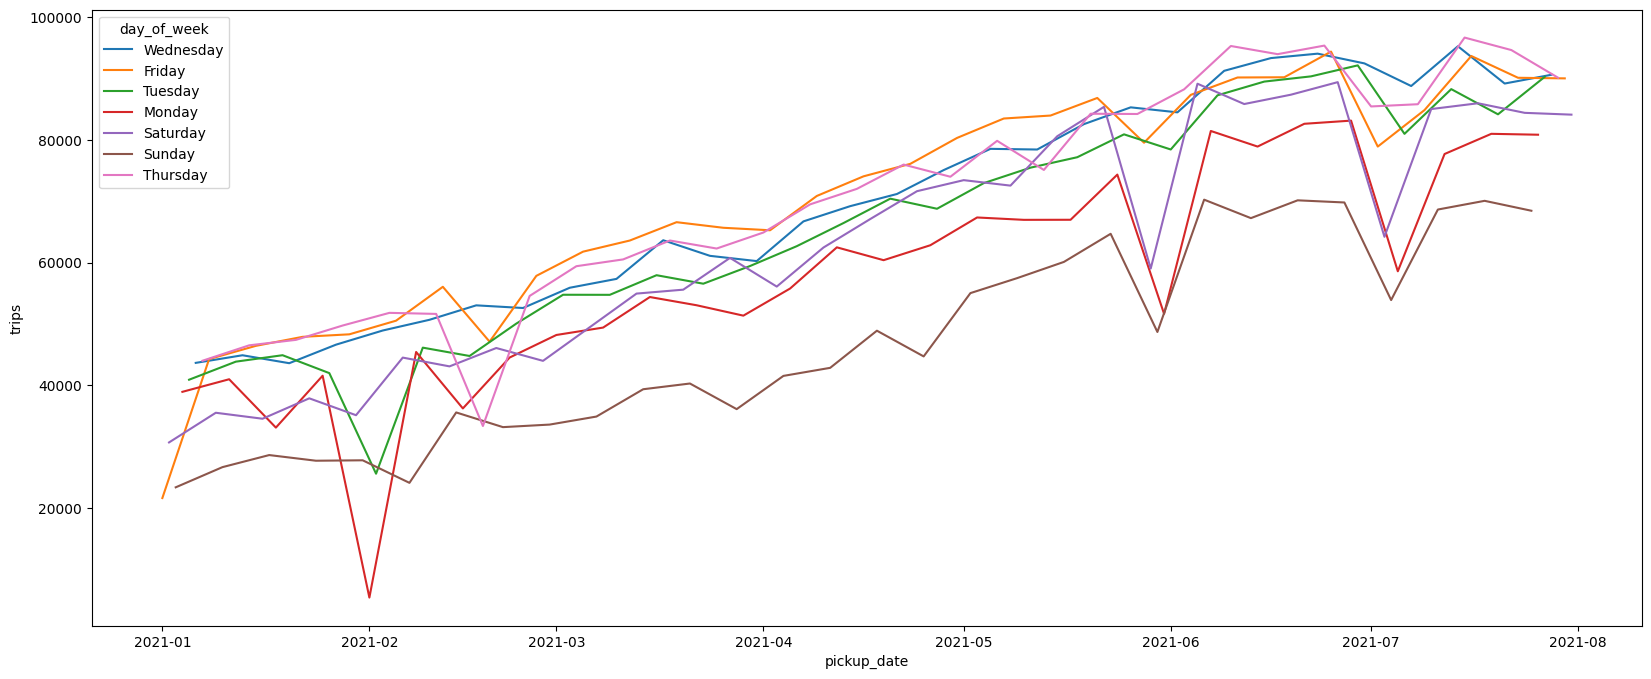

In [33]:
plt.subplots(figsize=(20, 8))
sns.lineplot(x='pickup_date', y='trips',hue = 'day_of_week', data = pd_df2)
plt.show()

In [34]:
median_data = pd_df2.groupby("day_of_week")["trips"].median().to_frame()
median_data = median_data.reset_index()
median_data

,day_of_week,trips
0,Friday,74073.0
1,Monday,57168.5
2,Saturday,62455.0
3,Sunday,43749.0
4,Thursday,73015.0
5,Tuesday,67614.5
6,Wednesday,70196.0


In [35]:
# 요일 정렬(일월화수목금토), replace를 통해 각 필드값을 변경한 컬럼을 생성
median_data["sort_dow"] = median_data["day_of_week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})
median_data

,day_of_week,trips,sort_dow
0,Friday,74073.0,5
1,Monday,57168.5,1
2,Saturday,62455.0,6
3,Sunday,43749.0,0
4,Thursday,73015.0,4
5,Tuesday,67614.5,2
6,Wednesday,70196.0,3


In [38]:
median_data = median_data.sort_values(by="sort_dow")
median_data

,day_of_week,trips,sort_dow
3,Sunday,43749.0,0
1,Monday,57168.5,1
5,Tuesday,67614.5,2
6,Wednesday,70196.0,3
4,Thursday,73015.0,4
0,Friday,74073.0,5
2,Saturday,62455.0,6


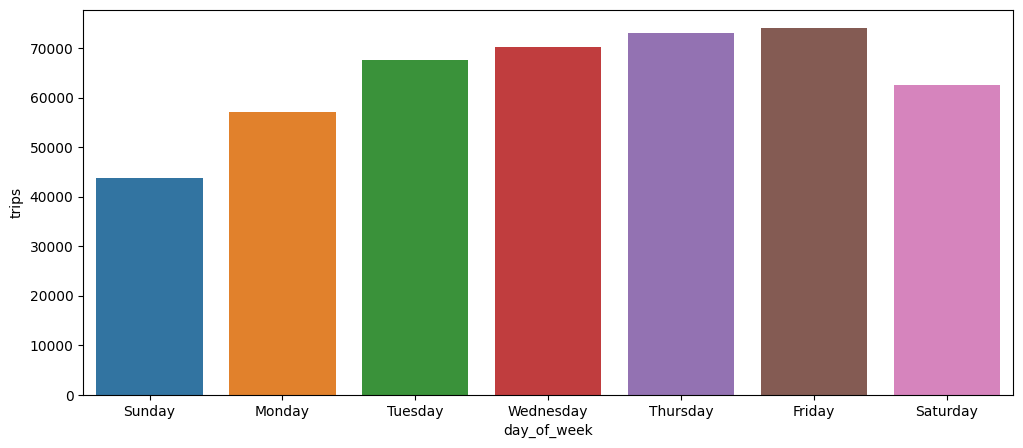

In [39]:
plt.figure(figsize=(12,5))
sns.barplot(
    x='day_of_week',
    y="trips",
    data=median_data)
plt.show()

In [40]:
# 결제 유형별 분석
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}

def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

In [41]:
parse_payment_type(3)

'No Charge'

In [42]:
spark.udf.register("parse_payment_type",parse_payment_type)

<function __main__.parse_payment_type(payment_type)>

In [43]:
query="""
SELECT parse_payment_type(payment_type),
    count(*) as trips,
    mean(fare_amount) as mean_fare_amount,
    std(fare_amount) as std_fare_amount
FROM cleaned
GROUP BY payment_type
"""

spark.sql(query).show()

+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount|   std_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10264368|12.231993889930267|11.087625547838066|
|                       No Charge|   59145|11.978582804970836|15.075633897695056|
|                         Dispute|   23806|12.730067209947066|14.892785718894652|
|                            Cash| 3152210|12.026132919443798| 13.26779356977227|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+



In [44]:
spark.stop()